In [1]:
# Cell 1: Imports
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.logger import configure


In [2]:
# Cell 2: Callback Definition
class RewardTrackerCallback(BaseCallback):
    """
    Callback for tracking rewards over training.
    Stores both episodic rewards and smoothed averages.
    """
    def __init__(self, verbose=0, check_freq=1000, window_size=100):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.window_size = window_size
        # Track both raw episode rewards and smoothed averages
        self.rewards = []
        self.smoothed_rewards = []
        self.episode_rewards = []
        self.timesteps = []
        
    def _on_step(self) -> bool:
        # Get current episode reward from the monitor
        if len(self.model.ep_info_buffer) > 0:
            latest_reward = self.model.ep_info_buffer[-1]["r"]
            self.episode_rewards.append(latest_reward)
        
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.model.logger.dir), 'timesteps')
            if len(y) > 0:
                # Store raw rewards
                self.rewards.append(y[-1])
                # Store smoothed rewards
                if len(y) >= self.window_size:
                    smoothed_reward = np.mean(y[-self.window_size:])
                    self.smoothed_rewards.append(smoothed_reward)
                    self.timesteps.append(x[-1])
        return True


In [3]:
# Cell 3: Environment Creation
def create_env(env_id="LunarLander-v2", log_dir="./logs/"):
    """Create a monitored vectorized environment"""
    os.makedirs(log_dir, exist_ok=True)
    
    def make_env():
        env = gym.make(env_id)
        env = Monitor(env, log_dir)
        return env
    
    env = DummyVecEnv([make_env])
    env = VecMonitor(env)
    return env


In [4]:
# Cell 4: Training Function
def train_baseline(total_timesteps=1_000_000, seed=42):
    """
    Train a baseline PPO agent on LunarLander-v2
    """
    # Set up logging
    log_dir = "./logs/lunarlander_baseline/"
    os.makedirs(log_dir, exist_ok=True)
    
    # Create environment
    env = create_env(log_dir=log_dir)
    
    # Configure logger
    logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
    
    # Create PPO model with standard hyperparameters for LunarLander
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        verbose=1,
        seed=seed
    )
    model.set_logger(logger)
    
    # Set up callback
    callback = RewardTrackerCallback(check_freq=10000, window_size=100)
    
    # Train the model
    model.learn(
        total_timesteps=total_timesteps,
        callback=callback
    )
    
    return model, callback


In [5]:
# Cell 5: Plotting Function
def plot_training_results(callback, title="PPO Baseline on LunarLander-v2"):
    """Plot training curves"""
    plt.figure(figsize=(10, 5))
    
    # Plot raw episode rewards with low alpha
    if len(callback.episode_rewards) > 0:
        episodes = np.arange(len(callback.episode_rewards))
        plt.plot(episodes, callback.episode_rewards, alpha=0.1, color='blue', label='Episode Rewards')
    
    # Plot smoothed rewards
    if len(callback.smoothed_rewards) > 0:
        plt.plot(callback.timesteps, callback.smoothed_rewards, 
                color='blue', linewidth=2, label='Smoothed Reward (100 ep)')
    
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Logging to ./logs/lunarlander_baseline/


c:\Users\bunny\anaconda3\envs\gym\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | -153     |
| time/              |          |
|    fps             | 861      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 99.3         |
|    ep_rew_mean          | -163         |
| time/                   |              |
|    fps                  | 735          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0072879726 |
|    clip_fraction        | 0.00869      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.0054      

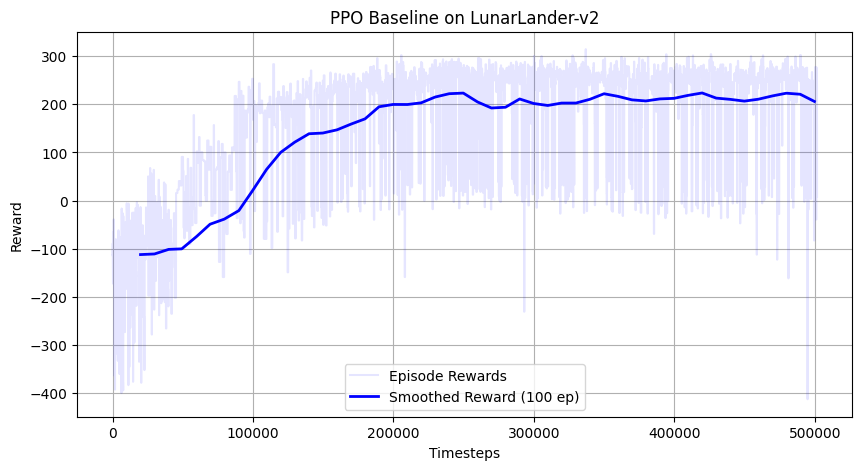

In [10]:
# Cell 6: Run Training
# You can adjust these parameters as needed
model, callback = train_baseline(total_timesteps=500_000)

# Cell 7: Plot Results
plot_training_results(callback)